In [32]:
# 1) 📦 IMPORT LIBRARIES AND SETUP ENVIRONMENT

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from sqlalchemy import create_engine, text

load_dotenv()

engine = create_engine(
    f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASS')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)

In [33]:
# 2) 📥 LOAD EMPLOYEE ENGAGEMENT RESPONSES JOINED TO CRM OUTCOMES

# This version corrects the join condition to use cs_manager_employee_id,
# which maps to employee_id in the engagement data.

query = """
SELECT
    ee."employee_id",                       -- Unique ID for each employee
    ee."survey_date",                      -- Date of survey submission
    ee."q1_expectations",
    ee."q2_tools",
    ee."q3_best_work",
    ee."q4_recognition",
    ee."q5_care_about_me",
    ee."q6_dev_support",
    ee."q7_my_opinions_count",
    ee."q8_mission_importance",
    ee."q9_team_quality",
    ee."q10_best_friend",
    ee."q11_progress_feedback",
    ee."q12_learning_growth",
    crm."contract_value_ARR",              -- Revenue outcome
    crm."onboarding_completion_days"       -- Operational outcome
FROM employee_engagement ee
JOIN customer_crm crm
    ON ee."employee_id" = crm."cs_manager_employee_id"
WHERE crm."contract_value_ARR" IS NOT NULL
  AND crm."onboarding_completion_days" IS NOT NULL
  AND ee."survey_date" IS NOT NULL;
"""

# Execute SQL and load into DataFrame
with engine.connect() as conn:
    df = pd.read_sql_query(sql=text(query), con=conn)

# Preview the result
df.head()

,employee_id,survey_date,q1_expectations,q2_tools,q3_best_work,q4_recognition,q5_care_about_me,q6_dev_support,q7_my_opinions_count,q8_mission_importance,q9_team_quality,q10_best_friend,q11_progress_feedback,q12_learning_growth,contract_value_ARR,onboarding_completion_days
0,E1212,2024-10-01,3.600181,3.102112,4.202821,3.306877,3.902739,5.000000,4.455833,3.041607,3.107604,4.106273,3.037276,2.598792,228635.24,53
1,E1212,2024-07-01,4.677621,5.000000,4.584385,3.886016,3.778418,3.853655,3.467486,4.176679,3.203076,2.677212,4.153721,4.014863,228635.24,53
2,E1212,2024-04-01,3.201862,3.083424,3.364406,4.243268,4.363918,4.422237,2.957929,3.999714,3.281757,4.281026,4.335354,3.179479,228635.24,53
3,E1212,2024-01-01,3.626017,4.140106,5.000000,3.633512,3.272471,3.206064,3.847729,3.297570,5.000000,4.151450,4.680208,3.790934,228635.24,53
4,E1212,2023-10-01,4.382567,4.066685,3.941109,2.899075,3.426188,4.421775,3.522585,4.843759,5.000000,4.459470,5.000000,4.504509,228635.24,53


In [34]:
# 3) 🧹 PREPROCESS: CLEAN & PREP DATA FOR ANALYSIS

# Step 1: Drop any rows where ARR or onboarding is missing
df = df.dropna(subset=["contract_value_ARR", "onboarding_completion_days"])

# Step 2: Convert ARR and onboarding time to numeric (just in case they were strings)
df["contract_value_ARR"] = pd.to_numeric(df["contract_value_ARR"], errors="coerce")
df["onboarding_completion_days"] = pd.to_numeric(df["onboarding_completion_days"], errors="coerce")

# Step 3: Convert all engagement question scores to numeric (some may be strings)
question_cols = [
    "q1_expectations", "q2_tools", "q3_best_work", "q4_recognition",
    "q5_care_about_me", "q6_dev_support", "q7_my_opinions_count",
    "q8_mission_importance", "q9_team_quality", "q10_best_friend",
    "q11_progress_feedback", "q12_learning_growth"
]

for col in question_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Step 4: Drop any remaining nulls that were created during type conversion
df = df.dropna()

# Step 5: Preview cleaned dataset
df.head()

,employee_id,survey_date,q1_expectations,q2_tools,q3_best_work,q4_recognition,q5_care_about_me,q6_dev_support,q7_my_opinions_count,q8_mission_importance,q9_team_quality,q10_best_friend,q11_progress_feedback,q12_learning_growth,contract_value_ARR,onboarding_completion_days
0,E1212,2024-10-01,3.600181,3.102112,4.202821,3.306877,3.902739,5.000000,4.455833,3.041607,3.107604,4.106273,3.037276,2.598792,228635.24,53
1,E1212,2024-07-01,4.677621,5.000000,4.584385,3.886016,3.778418,3.853655,3.467486,4.176679,3.203076,2.677212,4.153721,4.014863,228635.24,53
2,E1212,2024-04-01,3.201862,3.083424,3.364406,4.243268,4.363918,4.422237,2.957929,3.999714,3.281757,4.281026,4.335354,3.179479,228635.24,53
3,E1212,2024-01-01,3.626017,4.140106,5.000000,3.633512,3.272471,3.206064,3.847729,3.297570,5.000000,4.151450,4.680208,3.790934,228635.24,53
4,E1212,2023-10-01,4.382567,4.066685,3.941109,2.899075,3.426188,4.421775,3.522585,4.843759,5.000000,4.459470,5.000000,4.504509,228635.24,53


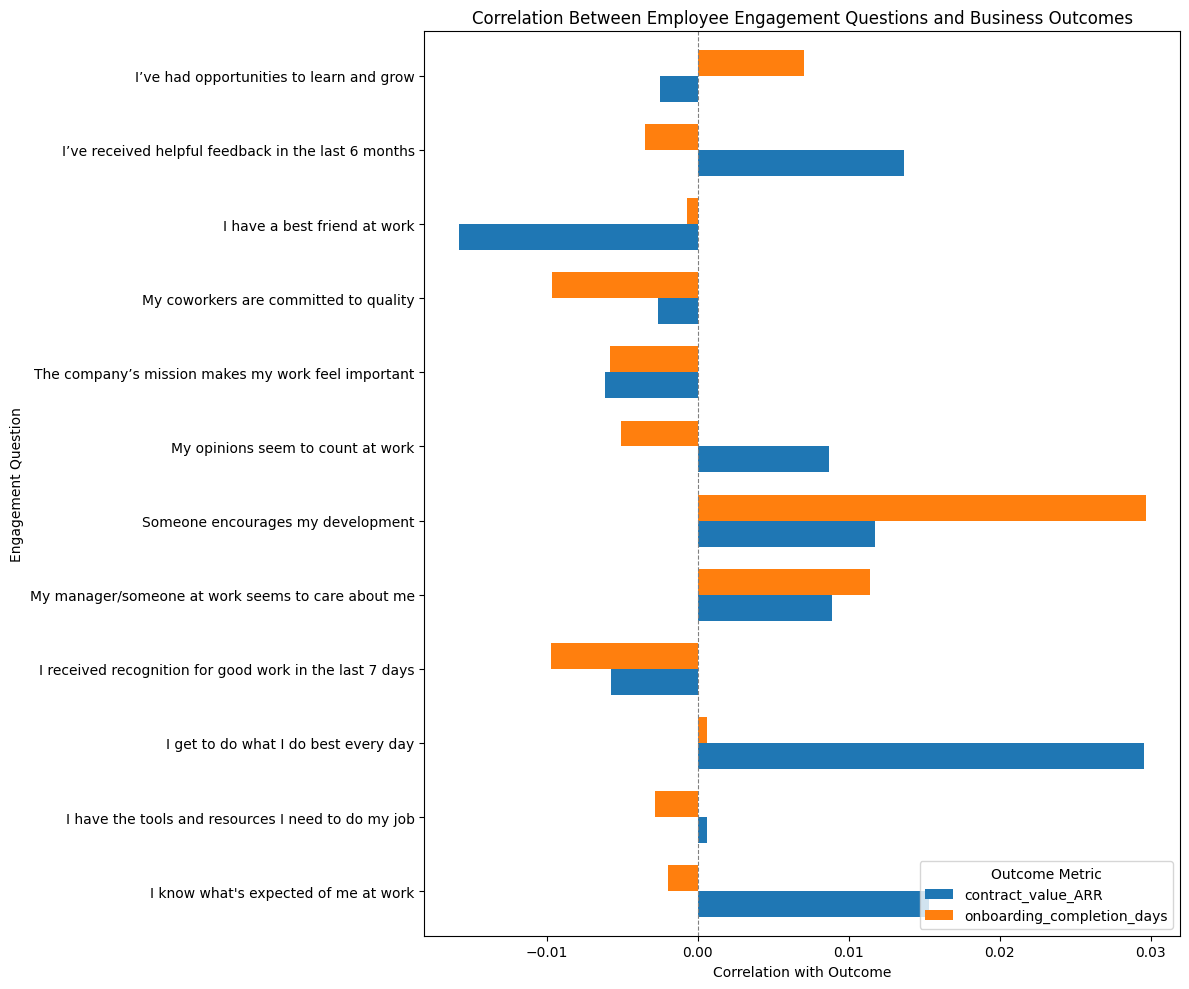

In [35]:
# 4) 📊 FOCUSED CORRELATION (HORIZONTAL): HUMAN-READABLE ENGAGEMENT vs OUTCOMES

# Step 1: Create a label map to translate field names to readable questions
question_labels = {
    "q1_expectations": "I know what's expected of me at work",
    "q2_tools": "I have the tools and resources I need to do my job",
    "q3_best_work": "I get to do what I do best every day",
    "q4_recognition": "I received recognition for good work in the last 7 days",
    "q5_care_about_me": "My manager/someone at work seems to care about me",
    "q6_dev_support": "Someone encourages my development",
    "q7_my_opinions_count": "My opinions seem to count at work",
    "q8_mission_importance": "The company’s mission makes my work feel important",
    "q9_team_quality": "My coworkers are committed to quality",
    "q10_best_friend": "I have a best friend at work",
    "q11_progress_feedback": "I’ve received helpful feedback in the last 6 months",
    "q12_learning_growth": "I’ve had opportunities to learn and grow"
}

# Step 2: Build correlation matrix again (subset to engagement vs outcomes)
focused_corr = df[question_cols + ["contract_value_ARR", "onboarding_completion_days"]].corr()
focused_corr = focused_corr.loc[question_cols, ["contract_value_ARR", "onboarding_completion_days"]]

# Step 3: Rename the rows using the label map
focused_corr.index = [question_labels[q] for q in focused_corr.index]

# Step 4: Plot horizontally
ax = focused_corr.plot(kind="barh", figsize=(12, 10), width=0.7)
plt.title("Correlation Between Employee Engagement Questions and Business Outcomes")
plt.xlabel("Correlation with Outcome")
plt.ylabel("Engagement Question")
plt.axvline(0, color="gray", linewidth=0.8, linestyle="--")
plt.legend(title="Outcome Metric", loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# 📥 LOAD AGGREGATED SALES REP ENGAGEMENT + TOTAL ARR

# This will load one row per sales rep, including their average engagement scores
# and the total ARR from all customers they’re assigned to.

from sqlalchemy import text

query_path = "queries/sales_rep_engagement_vs_arr.sql"  # Adjust if saved elsewhere

with open(query_path, "r") as file:
    query = file.read()

with engine.connect() as conn:
    rep_df = pd.read_sql_query(sql=text(query), con=conn)

# Preview the results
rep_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'sql/sales_rep_engagement_vs_arr.sql'